# Face Similarity score predictor


## Methodology
<ol>
<li>Load data</li>
<li>Blur images to remove noise</li>
<li>Detect faces and save dataset</li>
<li>resize all face images to constant</li>
<li>Extract features</li>
<li>Save features in file(number of lines = number of images)</li>
<li>Make clusters of given feature set</li>
<li>Find similarity score based on feature</li>
<li>Show faces with similarity score beneath</li>
</ol>

## Loading Data

### Mounting google drive which contains the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


### Import all libraries here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import csv
from mtcnn.mtcnn import MTCNN
from PIL import Image
from google.colab import files
from skimage.feature import hog
from scipy.spatial import distance

Using TensorFlow backend.


### Getting the data from the Data folder with os magic

In [ ]:
path = '/content/gdrive/My Drive/Data'

In [ ]:
data_folders = []#contains list of folders/classes
all_images = []#contains np array cv2 coded images of all jpg files in Data folder
print("The folders in the Data folder:")
for filename in os.listdir(path):
  print(filename)
  data_folders.append(path+'/'+filename)


for folders in data_folders:
  for filename in os.listdir(folders):
    if filename.endswith('jpg'):
      all_images.append(cv2.imread(folders+'/'+filename))

The folders in the Data folder:
Vishwang
Trinita
Shalini
Mom
Maheak
Aaheli
Trinita Dad
Trinita Mom
Adi


In [ ]:
print("Number of images found : "+str(len(all_images)))

Number of images found : 400


#### Sample Image

In [ ]:
def show_picture(img):
  #img_copy = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)
  ax.imshow(img)

In [ ]:
show_picture(all_images[69])

NameError: ignored

## Blurring images for noise removal

In [ ]:
def blur_image(img):
  blurred = cv2.GaussianBlur(img,(5,5),3)
  return blurred

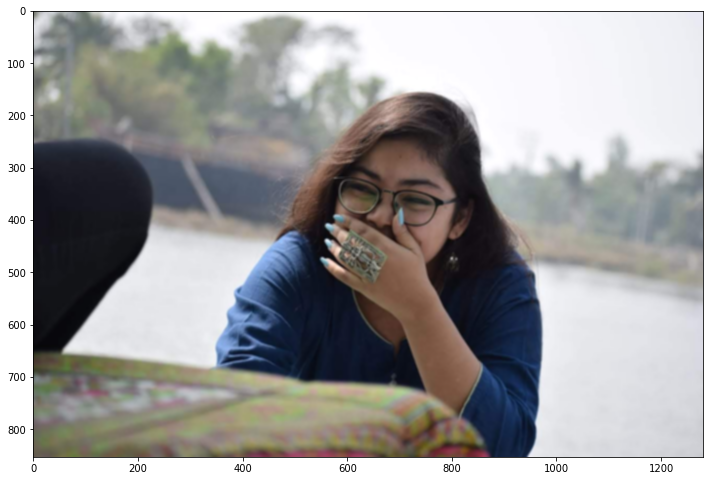

In [ ]:
show_picture(blur_image(all_images[69]))

## Face Detection

### Using Multi Multi-task Cascaded Convolutional Networks to detect faces

In [ ]:
def locate_faces(img):
  blurred = blur_image(img)
  detector = MTCNN(scale_factor=0.69)
  faces = detector.detect_faces(blurred)
  return faces

### get_faces returns all the face locations from a sigle image
img is the image, faces_list is the list returned by locate faces

In [ ]:
def get_faces(img, faces_list):
  only_faces = []
  for i in range(len(faces_list)):
  # get coordinates
    x1, y1, width, height = faces_list[i]['box']
    x2, y2 = x1 + width, y1 + height
    #choose face only if confidence greater tha 98%
    if faces_list[i]['confidence']>0.98:
      only_faces.append(img[y1:y2, x1:x2])
  return only_faces

### Only_faces is a list of lists which in turn contain the nd arrays of the faces themselves.
Populating this list.

In [ ]:
only_faces = []

In [ ]:
for img in all_images:
  faces = locate_faces(img)
  only_faces.append(get_faces(img,faces))

### Storing the faces in google drive under <b>Faces</b> folder

In [ ]:
i=0
face_path = '/content/gdrive/My Drive/Faces/'
for faces in only_faces:
  if faces:
    for face in faces:
      #show_picture(face)
      try:
        face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        im = Image.fromarray(face)
        im.save(face_path+str(i)+'.png')
        i += 1
      except:
        print('Face not detected')

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected


### Getting faces from faces folder

In [ ]:
face_path = '/content/gdrive/My Drive/Faces'
only_faces = []

In [ ]:
for face_file in os.listdir(face_path):
  img = cv2.imread(face_path+'/'+face_file)
  rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  only_faces.append(rgb)

## Resizing all faces

In [ ]:
w,h = (64,128)
dim = (w,h)
standard_faces =[cv2.resize(face,dim,interpolation = cv2.INTER_AREA) for face in only_faces]

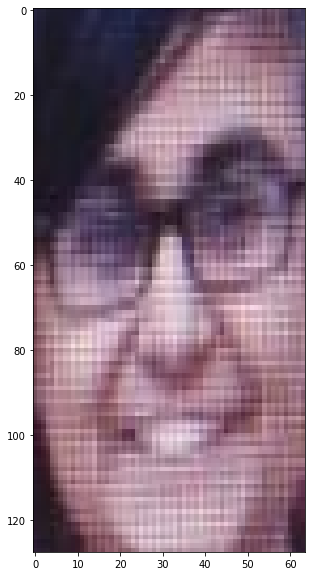

In [ ]:
show_picture(standard_faces[69])

## Extracting face features

In [ ]:
features = []
for face in standard_faces:
  fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8,8),
                      cells_per_block=(2,2), visualize=True, multichannel=True)
  features.append(fd)

In [ ]:
len(features)

856

In [ ]:
np.savetxt('face_features.txt',features,'%12.8f',delimiter=',',encoding='utf-8')

## Calculating distances between 2 features

In [ ]:
def calc_distance(img1,img2,mode='euclidian'):
  if mode == 'euclidian':
    return distance.euclidean(img1,img2)
  if mode =='chebyshev':
    return distance.chebyshev(img1,img2)
  if mode == 'manhattan':
    return distance.cityblock(img1,img2)
  if mode == 'minkowski':
    return distance.minkowski(img1,img2)
  if mode == 'canberra':
    return distance.canberra(img1,img2)
  if mode == 'correlation':
    return distance.correlation(img1,img2,)

## Getting features from features file

In [ ]:
with open('face_features.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()


In [ ]:
features = list(map(np.array,filecontents))

In [ ]:
def get_similarity_score(img1,img2,mode='euclidian'):
  dist = calc_distance(img1,img2,mode)
  return (1/(1+dist))

In [ ]:
calc_distance(features[92],features[95])

18.522091290457265